In [1]:
!pip install openbb

In [3]:
from openbb_terminal.sdk import openbb

libwebkit2gtk-4.0.so.37: cannot open shared object file: No such file or directory


Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

PyWry is not installed or missing required linux dependencies.

Install PyWry
pip install pywry --upgrade

Platform-specific notes
Here is the underlying web engine each platform uses you might need to install.

Linux
Pywry uses gtk-rs and its related libraries for window creation and Wry also needs WebKitGTK for WebView.
To activate interactive plots/tables in pywry window, please make sure the following packages are installed:

Arch Linux / Manjaro:
sudo pacman -S webkit2gtk

Debian / Ubuntu:
sudo apt install libwebkit2gtk-4.0-dev

Fedora / CentOS / AlmaLinux:
sudo dnf install gtk3-devel webkit2gtk3-devel

Continuing with default plotly behaviour (open in browser).

In [28]:
btc_usdt = openbb.crypto.load(symbol = 'BTC', to_symbol = 'USDT', source = 'CCXT', exchange = 'bitcoincom', start_date = '2022-01-01')
btc_usdt

,Open,High,Low,Close,Volume
date,,,,,
2022-01-01,46220.45,47922.20,46214.42,47715.98,17609.70287
2022-01-02,47722.39,47985.90,46664.51,47300.77,13007.85742
2022-01-03,47301.71,47555.00,45711.07,46430.60,15566.73780
2022-01-04,46445.97,47533.88,45556.68,45830.83,22609.25404
2022-01-05,45819.18,47062.88,42479.16,43438.90,24852.33126
...,...,...,...,...,...
2023-09-01,25928.11,26140.63,25337.24,25798.01,3646.51931
2023-09-02,25799.26,25977.77,25746.28,25861.43,1095.96629
2023-09-03,25861.44,26120.96,25807.47,25968.95,1244.27447


In [8]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
X = btc_usdt.drop('Close', axis=1)
y = btc_usdt['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters to tune for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf,
                             cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [10]:
from sklearn.ensemble import AdaBoostRegressor

param_grid_ada = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}

grid_search_ada = GridSearchCV(AdaBoostRegressor(), param_grid_ada,
                              cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_ada.fit(X_train, y_train)
best_ada = grid_search_ada.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [11]:
import xgboost as xgb

param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

grid_search_xgb = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid_xgb,
                              cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [12]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

base_learners = [
    ('rf', best_rf),
    ('ada', best_ada),
    ('xgb', best_xgb)
]

param_grid_stack = {
    'final_estimator__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

stack_reg = StackingRegressor(estimators=base_learners, final_estimator=Ridge())
grid_search_stack = GridSearchCV(stack_reg, param_grid_stack,
                                cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_stack.fit(X_train, y_train)
best_stack = grid_search_stack.best_estimator_


Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [13]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('ada', AdaBoostRegressor(n_estimators=100)),
    ('xgb', xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100))
])
voting_reg.fit(X_train, y_train)
vote_pred = voting_reg.predict(X_test)


In [15]:
# Making predictions with each of the models
rf_pred_tuned = best_rf.predict(X_test)
ada_pred_tuned = best_ada.predict(X_test)
xgb_pred_tuned = best_xgb.predict(X_test)
stack_pred_tuned = best_stack.predict(X_test)

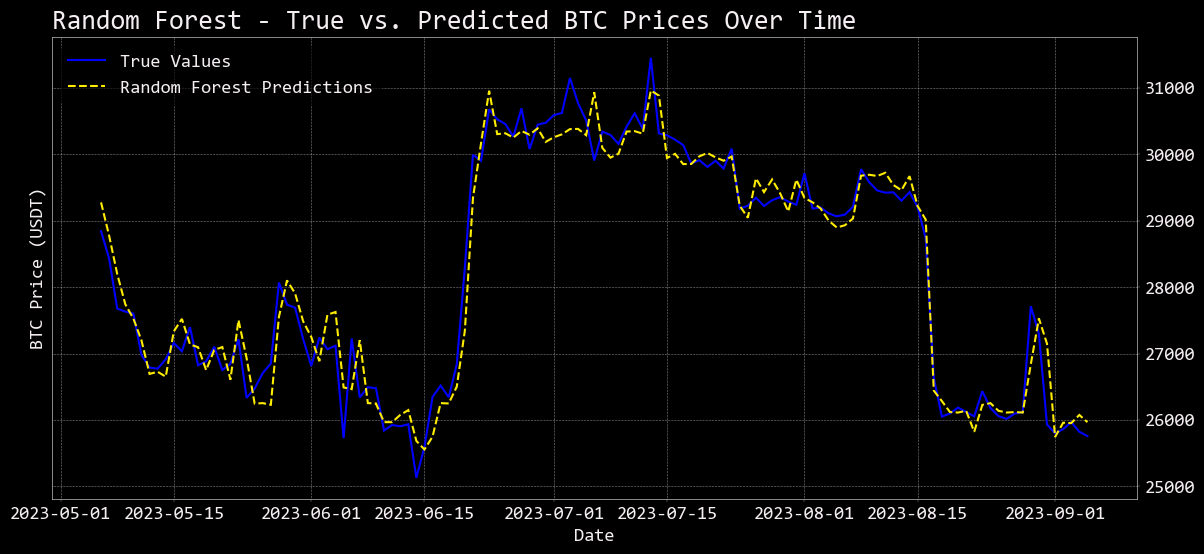

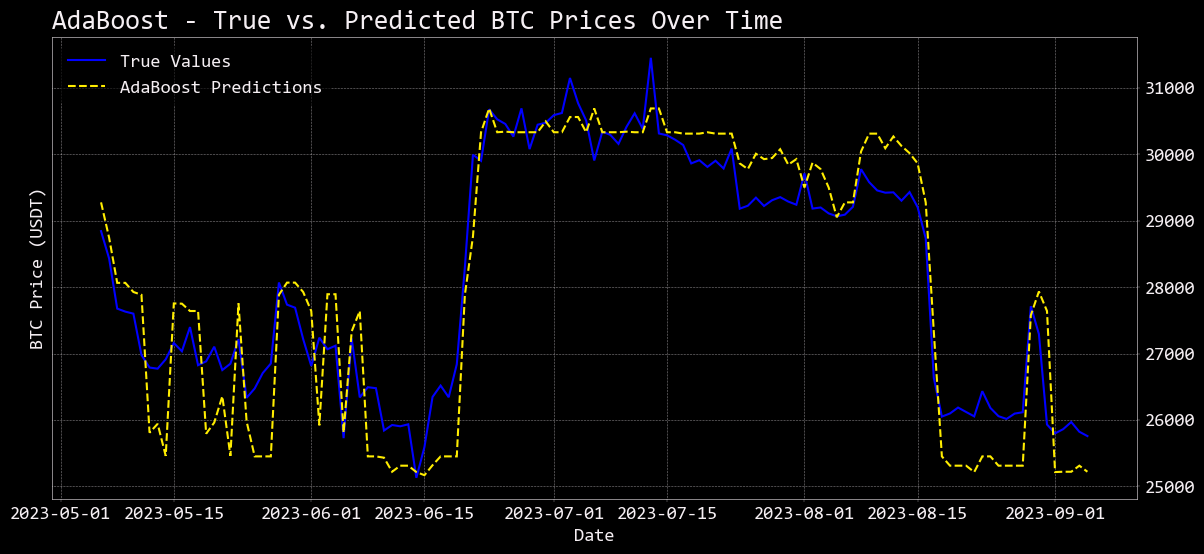

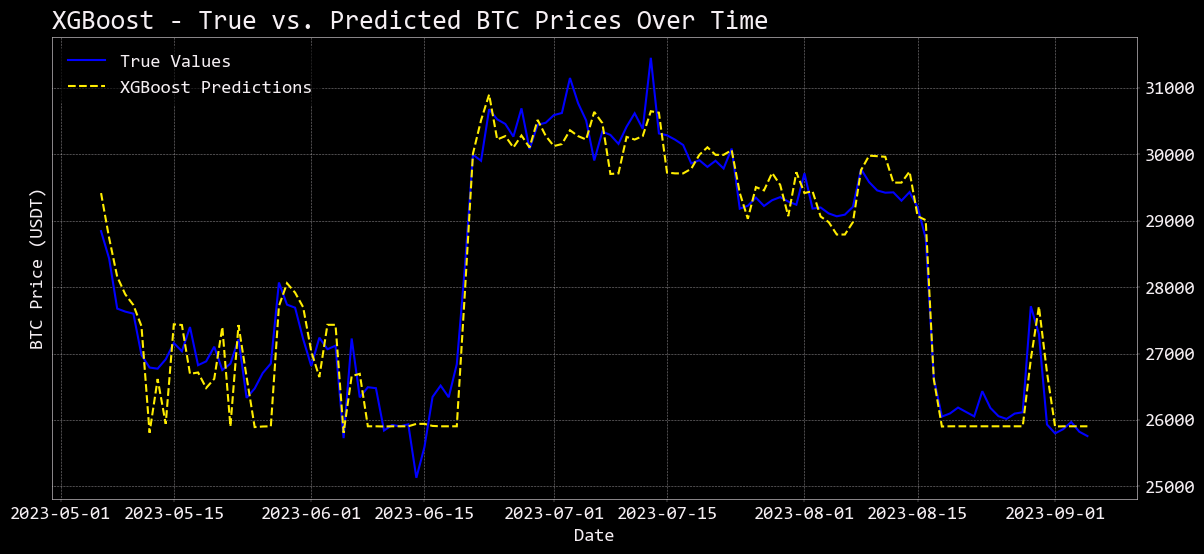

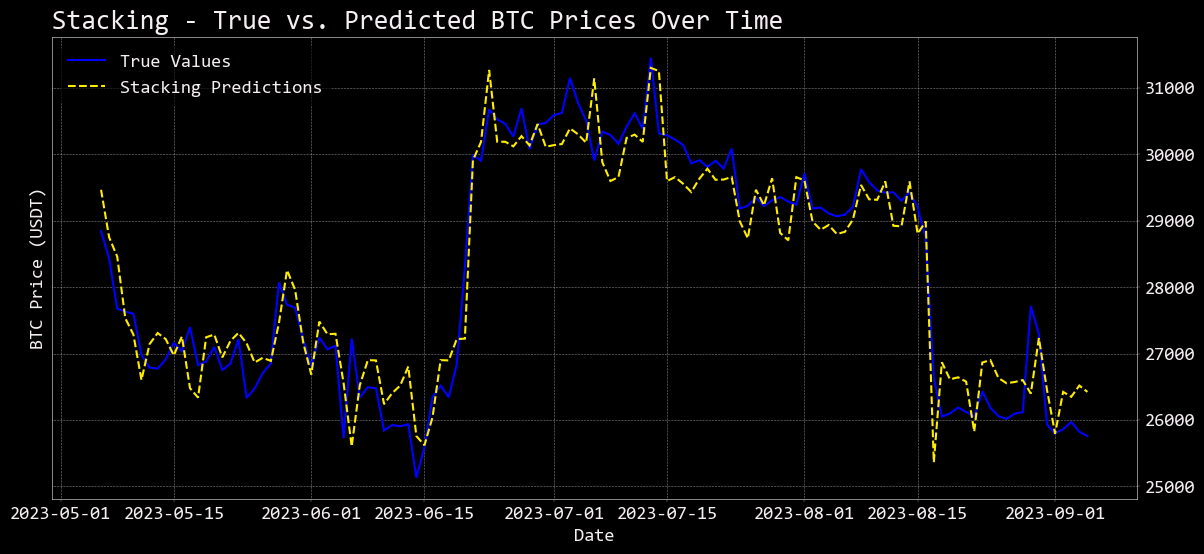

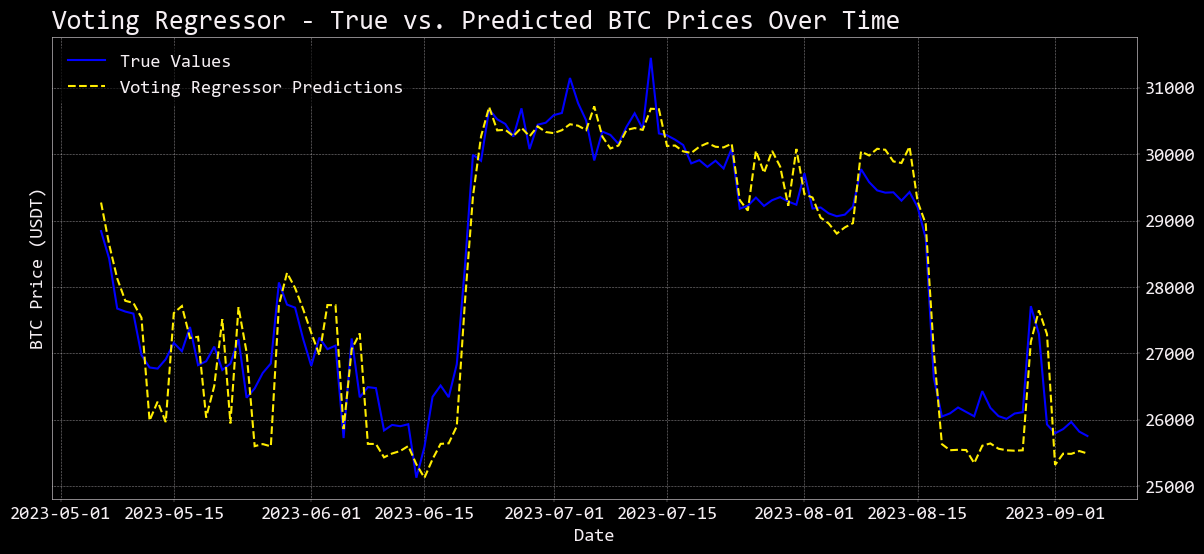

In [18]:
# Define a function to plot predictions
import matplotlib.pyplot as plt

def plot_predictions(model_name, predictions):
    plt.figure(figsize=(14, 6))
    plt.plot(X_test.index, y_test, label="True Values", color="blue")
    plt.plot(X_test.index, predictions, label=f"{model_name} Predictions", linestyle="--")

    plt.title(f"{model_name} - True vs. Predicted BTC Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("BTC Price (USDT)")
    plt.legend()
    plt.show()

# Use the function to plot each model's results
plot_predictions("Random Forest", rf_pred_tuned)
plot_predictions("AdaBoost", ada_pred_tuned)
plot_predictions("XGBoost", xgb_pred_tuned)
plot_predictions("Stacking", stack_pred_tuned)
plot_predictions("Voting Regressor", vote_pred)


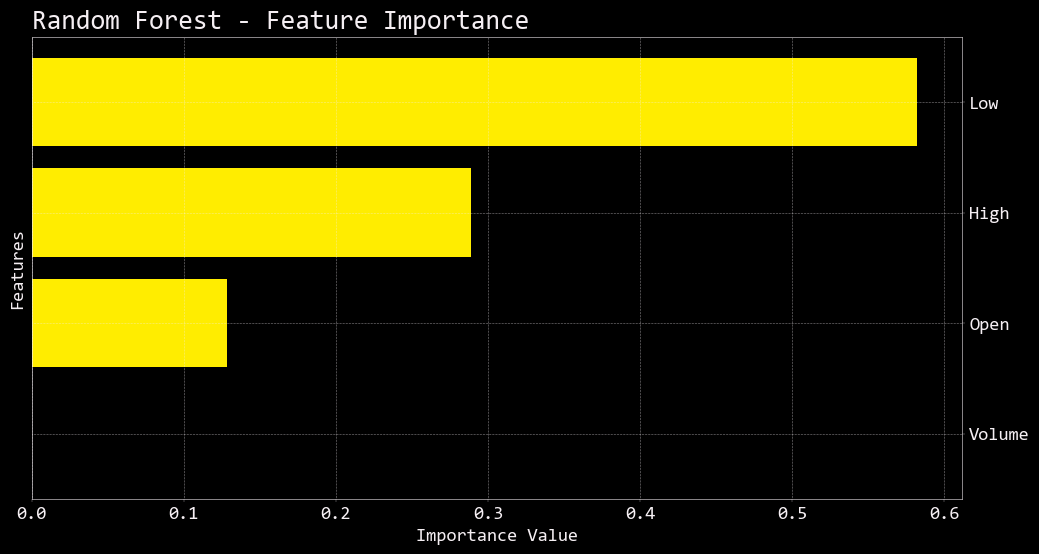

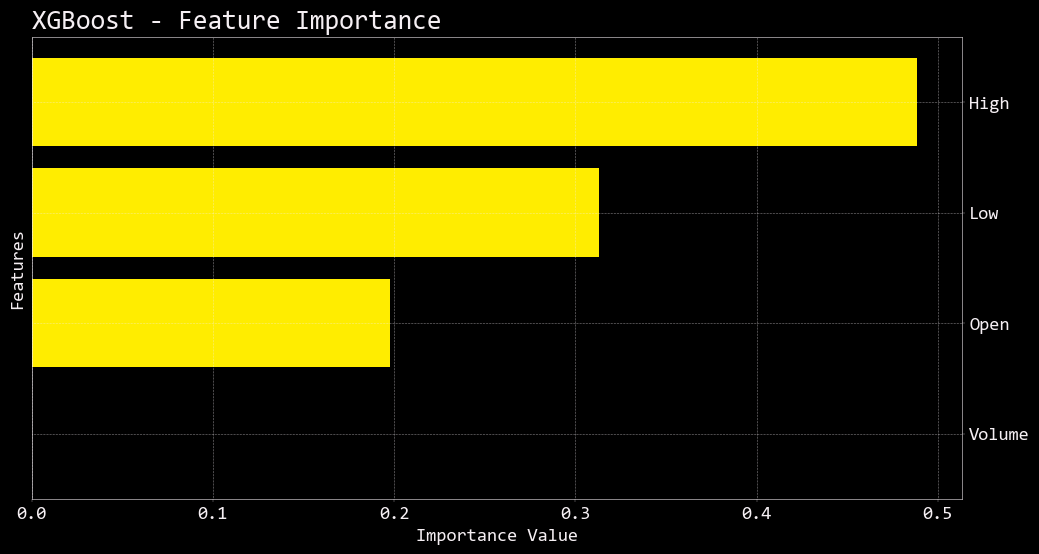

In [20]:
def plot_feature_importance(importance, names, model_name):
    feature_importance = list(zip(names, importance))
    sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    names, vals = zip(*sorted_feature_importance)
    plt.figure(figsize=(12,6))
    plt.barh(names, vals, align='center')
    plt.title(model_name + ' - Feature Importance')
    plt.xlabel('Importance Value')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()  # Display the most important feature at the top
    plt.show()

plot_feature_importance(best_rf.feature_importances_, X_train.columns, "Random Forest")
plot_feature_importance(best_xgb.feature_importances_, X_train.columns, "XGBoost")



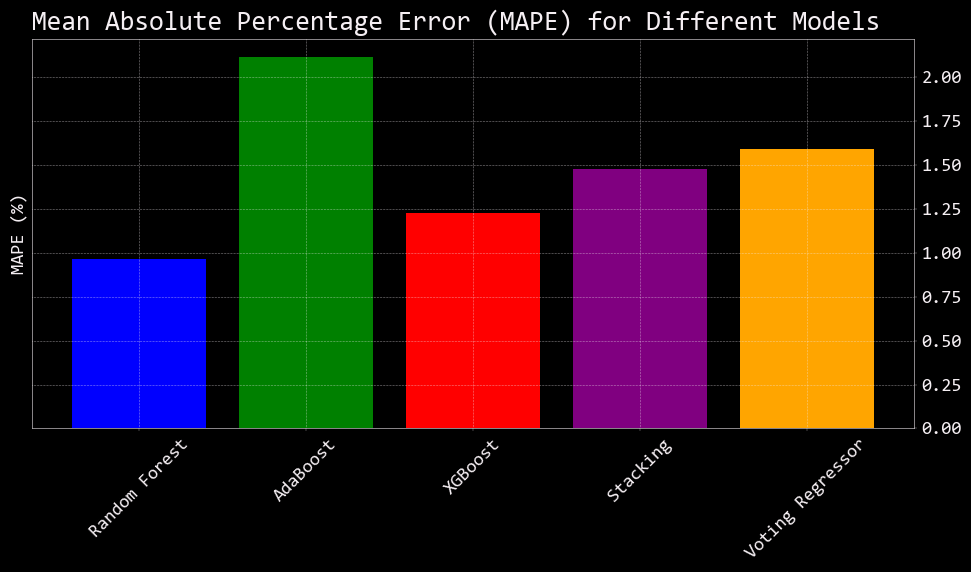

Random Forest MAPE: 0.97%
AdaBoost MAPE: 2.11%
XGBoost MAPE: 1.22%
Stacking MAPE: 1.48%
Voting Regressor MAPE: 1.59%


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def compute_mape(y_true, y_pred):
    # Guard against division by zero errors
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    valid_indices = y_true != 0
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    # Compute MAPE
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

# Calculate MAPE for each model
mape_rf = compute_mape(y_test, rf_pred_tuned)
mape_ada = compute_mape(y_test, ada_pred_tuned)
mape_xgb = compute_mape(y_test, xgb_pred_tuned)
mape_stack = compute_mape(y_test, stack_pred_tuned)
mape_vote = compute_mape(y_test, vote_pred)

# Visualization
models = ['Random Forest', 'AdaBoost', 'XGBoost', 'Stacking', 'Voting Regressor']
mape_values = [mape_rf, mape_ada, mape_xgb, mape_stack, mape_vote]

plt.figure(figsize=(10,6))
plt.bar(models, mape_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('MAPE (%)')
plt.title('Mean Absolute Percentage Error (MAPE) for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print out the computed MAPE values
print(f'Random Forest MAPE: {mape_rf:.2f}%')
print(f'AdaBoost MAPE: {mape_ada:.2f}%')
print(f'XGBoost MAPE: {mape_xgb:.2f}%')
print(f'Stacking MAPE: {mape_stack:.2f}%')
print(f'Voting Regressor MAPE: {mape_vote:.2f}%')


In [27]:
next_day_row = btc_usdt.iloc[-1:]
next_day_data = next_day_row.drop(columns=['Close'])  # Replace 'target_column' with your target's name
next_day_date = next_day_row.index[0].strftime('%Y-%m-%d')
  # Replace 'target_column' with your target's name

next_day_pred_rf = best_rf.predict(next_day_data)
print(f"Predictions for {next_day_date}:")
print(f"Random Forest BTC-USD Closing: {next_day_pred_rf[0]} USDT")

Predictions for 2023-09-05:
Random Forest BTC-USD Closing: 25967.038200000017 USDT
